In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets
import json, yaml
import os
import cv2

from SE3 import SE3, se3

data_dir = os.path.abspath(os.path.join(os.path.abspath(''), os.pardir)) + "/data"

with open(f'{data_dir}/blobs.json', 'r') as fs:
    blobs_dict = json.load(fs)

blobs_dict = {int(key): np.array(val) for key,val in blobs_dict.items()}

with open(f'{data_dir}/camera_calib_test1.json', 'r') as fs:
    mocap_data = json.load(fs)

# blobs_dict = {int(key): np.array(val) for key,val in blobs_dict.items()}
print(mocap_data.keys())

dict_keys(['Name', 'MeasurementCreation', 'ExportTime', 'User', 'QtmVersion', 'CurrentFrame', 'TraceRange', 'Timebase', 'Markers', 'Bones', 'RigidBodies', 'Timecode', 'Cameras'])


In [24]:
rbs_list = mocap_data['RigidBodies']
data_range = rbs_list[0]['Parts'][0]['Range']['End'] - 700
c_list = np.array([rbs_list[0]['Parts'][0]['Values'][i][0] for i in range(data_range)]) / 1000
R_list = np.array([rbs_list[0]['Parts'][0]['Values'][i][1] for i in range(data_range)])
# len(rbs_list[0]['Parts'][0]['Values'])
R_list.shape

(3086, 9)

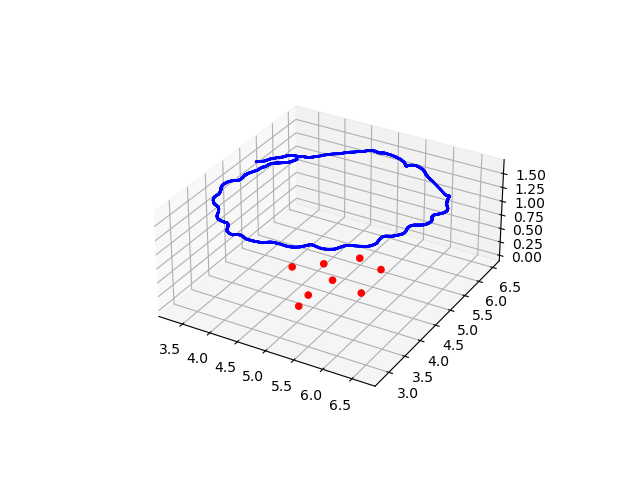

In [25]:
markers_list = mocap_data['Markers']
markers_pos = np.array([markers_list[i]['Parts'][0]['Values'] for i in range(len(markers_list))]) / 1000

target_marker_pos = np.mean(markers_pos[4:12], axis=1)
target_marker_pos = target_marker_pos[:,0:3].T

fig1 = plt.figure()
ax = fig1.add_subplot(111, projection='3d')
ax.scatter(target_marker_pos.T[:,0], target_marker_pos.T[:,1], target_marker_pos.T[:,2], color='r', alpha=1)
ax.scatter(c_list[:,0], c_list[:,1], c_list[:,2], s=1, color='b', alpha=1)
ax.set_aspect('equal')

In [30]:
info_dir = os.path.abspath( os.path.join(os.path.dirname(''), os.pardir)) + "/camera_info/"
with open(f'{info_dir}/camera_0.yaml', 'r') as fs:
    cam_info = yaml.safe_load(fs)
K = np.array(cam_info["camera_matrix"]["data"])
cam_dist = np.array(cam_info["distortion_coefficients"]["data"])
K_opt, dist_valid_roi = cv2.getOptimalNewCameraMatrix(K.reshape(3,3), cam_dist, (1600,1200), 1, (1600, 1200))

R_model2cam = np.array([
    [0, 1, 0],
    [0, 0, 1],
    [1, 0, 0],        
])

# SE2, transform image coordiantes to match the book
SE2_pix2image = np.array([
    [-1, 0,  1600],
    [0, -1, 1200],
    [0, 0,  1],
])

K_ = SE2_pix2image @ K_opt @ R_model2cam
inv_K_ = np.linalg.inv(K_)
K_t = np.block([
    [K_, np.zeros((3,1))],
    ])

In [28]:
target_marker_pos_h = np.vstack([target_marker_pos, np.ones(target_marker_pos.shape[1])])
print(target_marker_pos_h.shape)
blobs_proj_list = []
for i in range(data_range):
    c_mocap = c_list[i][0:3]
    R_mocap = R_list[i].reshape((3,3))
    T_mocap = SE3(R=R_mocap, c=c_mocap)
    blobs_proj_h = K_t @ T_mocap.G @ target_marker_pos_h
    blobs_proj = blobs_proj_h[0:2,:] / blobs_proj_h[2,:]
    blobs_proj_list.append(blobs_proj)


(4, 8)


interactive(children=(IntSlider(value=0, description='frame', max=3085), Output()), _dom_classes=('widget-inte…

<function __main__.update(frame=0)>

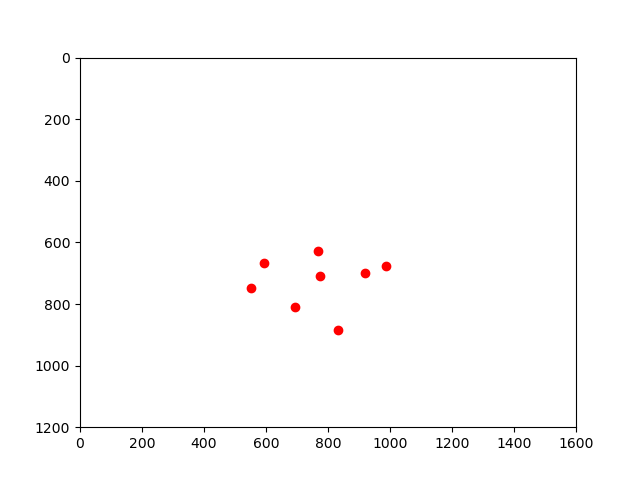

In [29]:

fig2 = plt.figure()
ax = fig2.add_subplot(111)
ax.set_xlim((0,1600))
ax.set_ylim((1200,0))

def update(frame=0):
    [l.remove() for l in ax.lines]
    [c.remove() for c in ax.collections]
    blobs = blobs_proj_list[frame]
    if blobs.shape[0]!=0:
        ax.scatter(blobs_proj_list[frame][0,:], blobs_proj_list[frame][1,:], color='r')

widgets.interact(update, frame=(0, data_range-1))


interactive(children=(IntSlider(value=0, description='frame', max=699), Output()), _dom_classes=('widget-inter…

<function __main__.update(frame=0)>

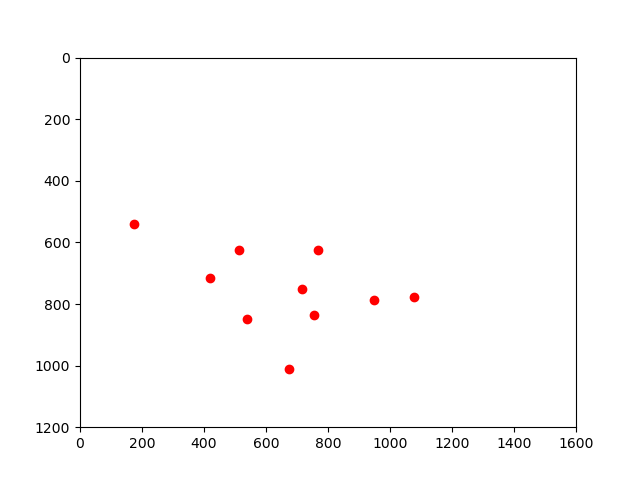

In [ ]:
# fig3 = plt.figure()
# ax = fig3.add_subplot(111)
# ax.set_xlim((0,1600))
# ax.set_ylim((1200,0))

# def update(frame=0):
#     [l.remove() for l in ax.lines]
#     [c.remove() for c in ax.collections]
#     blobs = blobs_dict[frame]
#     if blobs.shape[0]!=0:
#         ax.scatter(blobs_dict[frame][:,0], blobs_dict[frame][:,1], color='r')

# widgets.interact(update, frame=(0, len(blobs_dict)-1))


In [56]:
def find_E(x, xs):
    """
    Get the essential matrix between two pairs of cameras using the 8-point algorithm
    x, xs Nx3 camera homogenous coordinates, after applying K^-1 N >= 8
    """
    # n = x.shape[0]
    # A = np.zeros(n, 9)
    A = np.array([np.kron(xi, xsi) for xi, xsi in zip(x, xs)])
    U, s, V = np.linalg.svd(A)
    Ea = V.T[:,-1].reshape((3,3))
    Ua, sa, Va = np.linalg.svd(Ea)
    print(sa)
    print(Ua.shape, Va.shape)
    E = Ua @ np.diag([1,1,0]) @ Va.T
    return E
    
blobs_proj_list[0].shape
num_blobs = 8
x = inv_K_ @ np.vstack([blobs_proj_list[0], np.ones((1, num_blobs))])
xs = inv_K_ @ np.vstack([blobs_proj_list[1], np.ones((1, num_blobs))])
find_E(x.T, xs.T)

[7.07107005e-01 7.07106558e-01 6.97726432e-15]
(3, 3) (3, 3)


array([[ 0.07197825,  0.06239745, -0.99544963],
       [-0.06641093,  0.00460164, -0.00691152],
       [-0.99325726,  0.06641291, -0.06749604]])

In [ ]:
np.linalg.svd(np.eye(3))

(array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]),
 array([1., 1., 1.]),
 array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]))